# Preparing Text for Deep NLP Models (TextVectorization)

## Learning Objectives

- How to create a train-test-val split for Tensorflow datasets from a train-test split. 
- How to use a Keras TextVectorization Layer
- Demonstrate how tensorflow models using Sequences with Embedding Layers.


In [1]:
# Adding parent directory to python path
import sys, os
sys.path.append( os.path.abspath('../'))

In [2]:
## Load the autoreload extension
!pip install -U dojo_ds -q
import dojo_ds as fn
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_SOLUTION  as fn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Data

In [3]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [4]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')

In [5]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [6]:
import joblib
df = joblib.load('data/processed/processed-reviews.joblib')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 4362
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   asin               4363 non-null   object 
 1   reviewerID         4363 non-null   object 
 2   overall            4363 non-null   float64
 3   year               4363 non-null   int64  
 4   category           4363 non-null   object 
 5   text-raw           4363 non-null   object 
 6   length             4363 non-null   int64  
 7   text               4363 non-null   object 
 8   lower_text         4363 non-null   object 
 9   tokens             4363 non-null   object 
 10  no_stops           4363 non-null   object 
 11  no_stops_no_punct  4363 non-null   object 
 12  spacy_lemmas       4363 non-null   object 
 13  bigrams            4363 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 511.3+ KB


,asin,reviewerID,overall,year,category,text-raw,length,text,lower_text,tokens,no_stops,no_stops_no_punct,spacy_lemmas,bigrams
0,B007JINB0W,A1P9BVW2JB1OVL,3.0,2014,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Odd chewy texture: This has a odd chewy texture and not much flavor, but used as a substitute for pasta, it helps cut calories and carbs. I can tolerate it, but it isn't really tasty. Surprisingly, my husband enjoyed it more than I did. I just co...",291,"Odd chewy texture: This has a odd chewy texture and not much flavor, but used as a substitute for pasta, it helps cut calories and carbs. I can tolerate it, but it isn't really tasty. Surprisingly, my husband enjoyed it more than I did. I just co...","odd chewy texture: this has a odd chewy texture and not much flavor, but used as a substitute for pasta, it helps cut calories and carbs. i can tolerate it, but it isn't really tasty. surprisingly, my husband enjoyed it more than i did. i just co...","[odd, chewy, texture, :, this, has, a, odd, chewy, texture, and, not, much, flavor, ,, but, used, as, a, substitute, for, pasta, ,, it, helps, cut, calories, and, carbs, ., i, can, tolerate, it, ,, but, it, is, n't, really, tasty, ., surprisingly...","[odd, chewy, texture, :, odd, chewy, texture, much, flavor, ,, used, substitute, pasta, ,, helps, cut, calories, carbs, ., tolerate, ,, n't, really, tasty, ., surprisingly, ,, husband, enjoyed, ., could, n't, get, past, texture, (, rubber, noodle...","[odd, chewy, texture, odd, chewy, texture, much, flavor, used, substitute, pasta, helps, cut, calories, carbs, tolerate, n't, really, tasty, surprisingly, husband, enjoyed, could, n't, get, past, texture, rubber, noodles]","[odd, chewy, texture, odd, chewy, texture, flavor, substitute, pasta, help, cut, calorie, carb, tolerate, tasty, surprisingly, husband, enjoy, past, texture, rubber, noodle]","[(odd, chewy), (chewy, texture), (texture, odd), (odd, chewy), (chewy, texture), (texture, flavor), (flavor, substitute), (substitute, pasta), (pasta, help), (help, cut), (cut, calorie), (calorie, carb), (carb, tolerate), (tolerate, tasty), (tast..."
1,B007JINB0W,A5JZ2DBS9H3F6,1.0,2016,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck,77,Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck,fishy gross: they smell of fish and have a rubbery hard to chew texture. yuck,"[fishy, gross, :, they, smell, of, fish, and, have, a, rubbery, hard, to, chew, texture, ., yuck]","[fishy, gross, :, smell, fish, rubbery, hard, chew, texture, ., yuck]","[fishy, gross, smell, fish, rubbery, hard, chew, texture, yuck]","[fishy, gross, smell, fish, rubbery, hard, chew, texture, yuck]","[(fishy, gross), (gross, smell), (smell, fish), (fish, rubbery), (rubbery, hard), (hard, chew), (chew, texture), (texture, yuck)]"
2,B007JINB0W,A3VYMBAX7IFV3B,1.0,2014,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,One Star: MOM DID NOT LIKE THESE,32,One Star: MOM DID NOT LIKE THESE,one star: mom did not like these,"[one, star, :, mom, did, not, like, these]","[one, star, :, mom, like]","[one, star, mom, like]","[star, mom, like]","[(star, mom), (mom, like)]"
3,B007JINB0W,A25MLB8QXVM2LS,2.0,2018,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol ...,289,The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol ...,the noodles themselves are fine. the amazon label description claims they are certified ...: the noodles themselves are fine. the amazon label de

In [7]:
def create_groups(x):
    if x>=5.0:
        return "high"
    elif x <=2.0:
        return "low"
    else: 
        return None

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [8]:
## Use the function to create a new "rating" column with groups
df['rating'] = df['overall'].map(create_groups)
df['rating'].value_counts(dropna=False)

high    1868
low     1437
None    1058
Name: rating, dtype: int64

In [9]:
## Check class balance of 'rating'
df['rating'].value_counts(normalize=True)

high    0.565204
low     0.434796
Name: rating, dtype: float64

In [10]:
# Create a df_ml without null ratings
df_ml = df.dropna(subset=['rating']).copy()
df_ml.isna().sum()

asin                 0
reviewerID           0
overall              0
year                 0
category             0
text-raw             0
length               0
text                 0
lower_text           0
tokens               0
no_stops             0
no_stops_no_punct    0
spacy_lemmas         0
bigrams              0
rating               0
dtype: int64

In [11]:
## X - Option A)  lemmas
# def join_tokens(token_list):
#     joined_tokens = ' '.join(token_list)
#     return joined_tokens
# X = df_ml['spacy_lemmas'].apply(join_tokens)

# X - Option B) original raw text
X = df_ml['text']

# y - use our binary target 
y = df_ml['rating']
X.head(10)

1                                                                                                                                                                                 Fishy gross: They smell of fish and have a rubbery hard to chew texture. Yuck
2                                                                                                                                                                                                                              One Star: MOM DID NOT LIKE THESE
3     The noodles themselves are fine. The Amazon label description claims they are certified ...: The noodles themselves are fine. The Amazon label description claims they are certified non GMO and Vegan but the actual package contains no such symbol ...
5                                                                                                                                                                                                                 Two Stars: Not good lo

In [12]:
y.value_counts(normalize=True)

high    0.565204
low     0.434796
Name: rating, dtype: float64

# 📚 New For Today:

- Starting with a simple train-test-split for ML model (like in movie nlp project)
- Resampling Imbalanced training data
- Creating tensorflow dataset from X_train, y_train (so dataset is rebalanced)
- Creating tensorflow dataset (intended to be split in 2 ) for X_test and y_test

## From Train-Test Split for ML to Train-Test-Val Split for ANNs

In [13]:
# Perform 70:30 train test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
len(X_train_full), len(X_test)

(2313, 992)

### Using Sklearn's LabelEncoder

- Can't use text labels with neural networks.

In [14]:
y_train_full[:10]

4229    high
3075     low
3260     low
2235     low
843     high
81      high
1352     low
3938     low
1609     low
4360     low
Name: rating, dtype: object

In [15]:
# Instansiate label encoder
encoder = LabelEncoder()

# Fit and transform the training target
y_train_full_enc = encoder.fit_transform(y_train_full)#.values)

# Fit and tranform the test target
y_test_enc = encoder.transform(y_test)

y_train_full_enc[:10]

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [16]:
# Original Class names saved as .classes_
classes = encoder.classes_
classes

array(['high', 'low'], dtype=object)

In [17]:
# Can inverse-transform 
encoder.inverse_transform([0,1])

array(['high', 'low'], dtype=object)

### Undersampling Majority Class

In [18]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate a RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

In [19]:
try:
    X_train, y_train = sampler.fit_resample(X_train_full,y_train_full_enc)
except Exception as e:
    display(e)

ValueError('Expected 2D array, got 1D array instead:\narray=[\'EXCELLENT 0SP WW SUBSTITUTE: These are amazing! I am on weight watchers and these are 0sp! The taste is not good nor bad. I found they were tasteless, but really beef up a dish. It is especially helpful to have the mindset that I am eating carbs. I will continue to buy these for the convenience; even if it is just to trick my brain.\'\n "I found the texture too much like tapioca pearls for my personal preference: These really truly don\'t have any flavor if you rinse them enough, however, I found the texture too much like tapioca pearls for my personal preference.  Would recommend anyone looking for a good pasta or rice substitute to just stick with shredded cauliflower."\n \'Tasteless: These have no flavor.  They are a waste of space.  They have not nutritional value.  I prefer to make zucchini noodles or kelp noodles for when I craving a noodle dish.\'\n ...\n \'Two Stars: several of the packages arrive punctured and leak

In [20]:
# Fit_resample on the reshaped X_train data and y-train data
X_train, y_train_enc = sampler.fit_resample(X_train_full.values.reshape(-1,1),
                                        y_train_full_enc)
X_train.shape

(2012, 1)

In [21]:
# Flatten the reshaped X_train data back to 1D
X_train = X_train.flatten()
X_train.shape

(2012,)

In [22]:
# Check for class balance
pd.Series(y_train_enc).value_counts()

0    1006
1    1006
dtype: int64

## Previous Class' ML Model

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1006
           1       0.98      0.96      0.97      1006

    accuracy                           0.97      2012
   macro avg       0.97      0.97      0.97      2012
weighted avg       0.97      0.97      0.97      2012



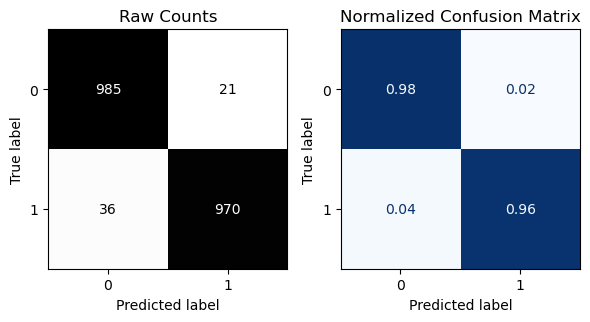


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       561
           1       0.95      0.93      0.94       431

    accuracy                           0.95       992
   macro avg       0.95      0.95      0.95       992
weighted avg       0.95      0.95      0.95       992



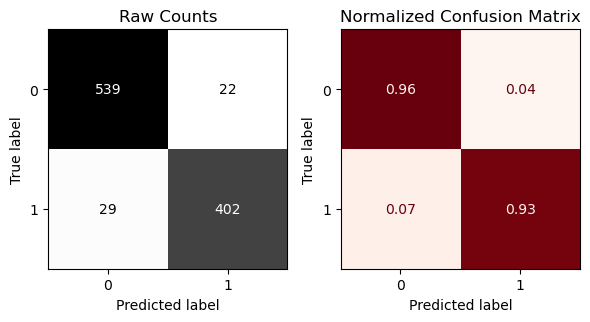

In [25]:
## Create a model pipeline 
count_pipe = Pipeline([('vectorizer',  CountVectorizer()), 
                       ('naivebayes',  MultinomialNB())])

count_pipe.fit(X_train, y_train_enc)
fn.evaluate.evaluate_classification(count_pipe, X_train, y_train_enc, X_test, y_test_enc,)

In [26]:
# # Admin: Saving  for Demo functions in part 1
# import joblib
# fpath_joblib = "../Lecture 1 Pt1 - Making a Custom Module/example-clf-model-with-data.joblib"
# save_for_part1= {'model':count_pipe, 'training data': [X_train, y_train_enc],'test data':[X_test, y_test_enc]}
# joblib.dump(save_for_part1, fpath_joblib)

# Preparing For Deep NLP (Train-Test-Val Datasets)

## 🕹️ Prepare Tensorflow Datasets

Since we already have train/test X and y vars, we will make 2 dataset objects using tf.data.Dataset.from_tensor_slices.

1. The training dataset using X_train, y_train (that we resampled/balanced)
2. The val/test dataset using X_test, y-test.

We will then split the val/test dataset into a val/test split.

<!-- 
### T/T/V Split - Order of Operations (if using 1 dataset object)

1) **Create full dataset object & Shuffle Once.**
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) **Add shuffle to the train dataset only.**
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) **Add .batch to all splits (default batch size=32)**
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets -->

In [27]:
# Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
# Shuffle dataset once
train_ds = train_ds.shuffle(buffer_size=len(train_ds),
                            reshuffle_each_iteration=False)

Create a test and validation dataset using X_test,y_test

In [28]:
# Convert test to dataset object and split
val_test_split_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
val_test_split_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [29]:
# Calculate # of samples for 50/50 val/test split
n_val_samples =  int(len(val_test_split_ds) * .5)
n_val_samples

496

In [30]:
## Perform the val/test split
## Create the validation dataset
val_ds = val_test_split_ds.take(n_val_samples)

## Create the test dataset
test_ds = val_test_split_ds.skip(n_val_samples)

In [31]:
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(2012, 496, 496)

### Adding Shuffling and Batching

Let's examine a single element.

In [32]:
# display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"I love these!: I love these!!! The noodle with oyster sauce and seaweed is gorgeous! I don't have to worry about taking in too much calories, meanwhile sparing my stomach of any suffering. Great product :)", shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


In [33]:
# taking a sample  (same result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"I love these!: I love these!!! The noodle with oyster sauce and seaweed is gorgeous! I don't have to worry about taking in too much calories, meanwhile sparing my stomach of any suffering. Great product :)", shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


> Shuffle the training data at the end of each epoch

In [34]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds))

In [35]:
# taking a sample  (different result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"worse food I have ever had: Honestly there is a reason they are called Miracle Noodle. It's a miracle anyone ever eats them twice. OMG...worse food I have ever had.", shape=(), dtype=string) 

 tf.Tensor(1, shape=(), dtype=int64)


In [36]:
# taking a sample  (different result)
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"Make sure you know how to prepare this specific noodle!: If you know how to prepare the product, it can taste just like normal noodles.\n\nI love the invention of shirataki noodles. If you're like me, indulging in noodle-based meals can be too easy.\n\nWith this product, you're free and able to stuff your face with pasta and noodles.", shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


> Add batching (use 32 for batch_size)

In [37]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32

# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)


# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 63 training batches.
 There are 16 validation batches.
 There are 16 testing batches.


In [38]:
# taking a sample - now 32 observations instead of 1
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)


tf.Tensor(
[b"tastes ok, it's just the texture...: I planned to use this to replace rice in different dishes, but really couldn't because the consistency is so strange. I guess that's to be expected with a product that is 100% fiber and 0 calories; but it's just so off-putting. They really do absorb the taste of whatever you cook them in, but they feel like tiny bits of rubber in your mouth. I've tried the noodles too, and they were slightly better. I really hope someone comes up with a way to make this stuff more palatable. Maybe it could be used it make fake tapioca pudding?\nPlus, when you open the package, it smells like old fish."
 b"I like this set because it allowed me to try each ...: I'm really enjoying the Miracle Noodles!  I like this set because it allowed me to try each of them to see which I liked best and so far I prefer the  Fettuccini.  These are perfect if you are on diet that does not allow gluten and can be used for so many different dishes."
 b'Rubbery but workable

A single element now contains 32 samples since we set  batch_size to 32.

## 📚 Vectorizing Text with Keras's TextVectorization Layer (Demo)

### TextVectorization Layer - Demo Count Vectorization

Flexible layer that can convert text to bag-of-words or sequences.

In [39]:
# Create text Vectorization layer - set to count vectorization
count_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count",
)
count_vectorizer

In [40]:
# Before training, only contains the out of vocab token ([UNK])
count_vectorizer.get_vocabulary()

['[UNK]']

In [41]:
# Was [[]]
example_text = ['Sometimes I love this vacuum, sometimes i hate this vacuum']

In [42]:
# Fitting the vectorizer using .adapt
count_vectorizer.adapt(example_text)

# Check the vocabulary after training the layer.
count_vectorizer.get_vocabulary()#[:10]

2024-02-07 22:17:41.871060: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


['[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate']

In [43]:
# Convert example to count-vectorization
counts = count_vectorizer(example_text)
print(counts)

tf.Tensor([[0. 2. 2. 2. 2. 1. 1.]], shape=(1, 7), dtype=float32)


- Size of vectorized text - column for every word in vocab

In [44]:
# Getting the counts as as DataFrame 
example_counts_df = pd.DataFrame(counts.numpy(), 
                         columns=count_vectorizer.get_vocabulary())
example_counts_df

,[UNK],vacuum,this,sometimes,i,love,hate
0,0.0,2.0,2.0,2.0,2.0,1.0,1.0


### TextVectorization Layer - Demo Sequence Vectorization

- Output_mode='int' returns sequences.
- Length is set by data scientist, use 30 for demo

In [45]:
# Create text Vectorization layer for sequences
demo_sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=30
)

In [46]:
# Check the vocabulary of the new sequence vectorizer.
demo_sequence_vectorizer.get_vocabulary()

['', '[UNK]']

In [47]:
# Fit the vectorizer using .adapt
demo_sequence_vectorizer.adapt(example_text)

# Check the vocabulary after training the layer
demo_sequence_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate']

In [48]:
# SAVING VOCAB FOR DEMO
# Getting list of vocab 
vocab = demo_sequence_vectorizer.get_vocabulary()

# Save dictionaries to look up words from ints 
int_to_str  = {idx:word for idx, word in enumerate(vocab)} # Dictionary Comprehension
# int_to_str = dict(zip( range(len(vocab)), vocab )) # Dict Constructor + 
int_to_str

{0: '',
 1: '[UNK]',
 2: 'vacuum',
 3: 'this',
 4: 'sometimes',
 5: 'i',
 6: 'love',
 7: 'hate'}

In [49]:
# Convert example to sequences
sequences = demo_sequence_vectorizer(example_text)
print(sequences.numpy())

[[4 5 6 3 2 4 5 7 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [50]:
try:
    pd.DataFrame(sequences, columns = vocab)
except Exception as e:
    display(e)

ValueError('Shape of passed values is (1, 30), indices imply (1, 8)')

In [51]:
sequences = sequences.numpy()
sequences

array([[4, 5, 6, 3, 2, 4, 5, 7, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])

In [52]:
for val in sequences[0]:
    print(f"{val} = {int_to_str[val]}")

4 = sometimes
5 = i
6 = love
3 = this
2 = vacuum
4 = sometimes
5 = i
7 = hate
3 = this
2 = vacuum
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 
0 = 


## Embedding Layer

In [53]:
# Saving the Size of the Vocab
VOCAB_SIZE = demo_sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

8

The embedding layer needs the number of words in the input (input_dim), and the desired embedding dimensions. (e.g. 100,200,300).

Arbitrary

In [54]:
# Create embedding layer of desired # of values
EMBED_DIM = 20
embedding_layer = layers.Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_DIM)
embedding_layer

In [55]:
# Minimum Model Needed to Create Embedding Layer for Vocab

demo_embed = Sequential()
demo_embed.add(demo_sequence_vectorizer)
demo_embed.add(embedding_layer)
demo_embed.compile(optimizer='adam', loss='mse')
demo_embed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 30, 20)            160       
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


### Demonstrating Sequence to Vector Embedding Lookup 

In [56]:
# Convert example to sequences
sequences = demo_sequence_vectorizer(example_text).numpy()
print(sequences)

[[4 5 6 3 2 4 5 7 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [57]:
# Embedding has row each word with EMBED_DIM of 100
demo_sequence_vectorizer.vocabulary_size(), EMBED_DIM

(8, 20)

In [58]:
# Get the weights from the embedding layer (this is your actual embedding matrix)
embedding_weights = demo_embed.layers[1].get_weights()[0]
embedding_weights.shape

(8, 20)

In [59]:
sequences[0]

array([4, 5, 6, 3, 2, 4, 5, 7, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
for val in sequences[0]:
    print(f"{val} = {int_to_str[val]}")
    print(embedding_weights[:,val])
    print()

4 = sometimes
[-0.04219389  0.03595319  0.04545214 -0.01839088 -0.02627729 -0.02987566
  0.03839504  0.03009173]

5 = i
[ 0.01523323 -0.03725255 -0.00896059  0.02789192 -0.0343127   0.02477567
 -0.02094598  0.00953519]

6 = love
[ 0.04704999 -0.00377146  0.00314702 -0.01847179  0.03634495 -0.04530361
  0.03622821  0.00262345]

3 = this
[ 0.04499895 -0.02374592 -0.01131532  0.02195575 -0.01845275 -0.03095883
  0.0432061   0.03753665]

2 = vacuum
[-0.01412892  0.04154279 -0.01658783 -0.01240187 -0.04493154  0.0062269
 -0.04448916  0.00422785]

4 = sometimes
[-0.04219389  0.03595319  0.04545214 -0.01839088 -0.02627729 -0.02987566
  0.03839504  0.03009173]

5 = i
[ 0.01523323 -0.03725255 -0.00896059  0.02789192 -0.0343127   0.02477567
 -0.02094598  0.00953519]

7 = hate
[-0.03320879  0.00627219 -0.02446803 -0.00765396  0.03378871 -0.01354297
 -0.0372517   0.04971505]

3 = this
[ 0.04499895 -0.02374592 -0.01131532  0.02195575 -0.01845275 -0.03095883
  0.0432061   0.03753665]

2 = vacuum
[-0

### Word Vectors 

In [61]:
# Prepare the words and their corresponding vectors
vector_dict = {}
for i, word in int_to_str.items():#tokenizer.word_index.items():
    # Save the weights for word (based on numeric index)
    vector_dict[word]= embedding_weights[i] 

    # vector_list.append(embedding_weights[i])
vector_dict.keys()

dict_keys(['', '[UNK]', 'vacuum', 'this', 'sometimes', 'i', 'love', 'hate'])

In [62]:
# Display the vector for "love"
vector_dict['love']

array([ 0.00170036, -0.04185566, -0.04448916,  0.0432061 ,  0.03839504,
       -0.02094598,  0.03622821, -0.0372517 ,  0.01225194, -0.03232763,
        0.02787178, -0.02258011,  0.01157136,  0.00900253, -0.02098697,
       -0.04244393,  0.00142006,  0.01115788,  0.0428837 , -0.02787268],
      dtype=float32)

In [63]:
# Display the vector for "hate"
vector_dict['hate']

array([-0.04104025, -0.03007517,  0.00422785,  0.03753665,  0.03009173,
        0.00953519,  0.00262345,  0.04971505, -0.01791079, -0.01335462,
        0.00937118,  0.04725314, -0.03905516, -0.01035707, -0.02476431,
       -0.04589201,  0.03127159, -0.02651983,  0.03338357,  0.03408468],
      dtype=float32)

In [64]:
# Vectors can be added/subtracted to get output vector - then find most similar word  
vector_dict['hate'] + vector_dict['love'] + vector_dict['vacuum']

array([-0.08507681, -0.06556724, -0.05684913,  0.06942742,  0.11393891,
       -0.02037138,  0.04199868, -0.01200468, -0.04337714, -0.02409926,
        0.04888433,  0.02546859, -0.0747076 , -0.03938666, -0.01661208,
       -0.05171802,  0.02587663, -0.03398604,  0.02957311, -0.03991873],
      dtype=float32)

## Word Embeddings Demo (Pre-Trained)

###  Pretrianed Word Embeddings with GloVe

- [Click here](https://nlp.stanford.edu/data/glove.6B.zip) to start donwnloading GloVe zip file (glove.6B.zip)
- Unzip the downloaded zip archive.
- Open the extracted folder and find the the `glove.6B.100d.txt` file. (Size is over 300MB )
- Move the text file from Downloads to the same folder as this notebook.
- **Make sure to ignore the large file using GitHub Desktop**

In [66]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("data/glove/glove.6B.100d.txt", binary=False, no_header=True)

In [67]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['king']
vector

array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
        0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
        0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
       -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
        0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
        0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
       -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
        0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
       -0.34311 ,  0.59789 , -0.58417 ,  0.068995,  0.23944 , -0.85181 ,
        0.30379 , -0.34177 , -0.25746 , -0.031101, -0.16285 ,  0.45169 ,
       -0.91627 ,  0.64521 ,  0.73281 , -0.22752 , 

In [68]:
vector.shape

(100,)

In [69]:
# Find similarity between words
glove_model.similarity('king', 'queen')

0.7507691

In [70]:
# Perform word math
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380331993103),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991)]

In [71]:
# We can use glove to calculate the most similar
glove_model.most_similar('king')

[('prince', 0.7682329416275024),
 ('queen', 0.7507689595222473),
 ('son', 0.7020888328552246),
 ('brother', 0.6985775828361511),
 ('monarch', 0.6977890729904175),
 ('throne', 0.691999077796936),
 ('kingdom', 0.6811410188674927),
 ('father', 0.6802029013633728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

In [72]:
# Manually calculating new vector for word math
new_vector = glove_model['king'] - glove_model['man'] + glove_model['woman']
new_vector

array([-0.10231996, -0.81294006,  0.10211003,  0.985924  ,  0.34218282,
        1.09095   , -0.48912996, -0.05616698, -0.21029997, -1.02996   ,
       -0.86851   ,  0.36786997,  0.01960999,  0.59259   , -0.23190099,
       -1.016919  , -0.01218399, -1.17194   , -0.52329   ,  0.60645   ,
       -0.98537004, -1.001028  ,  0.48913902,  0.630072  ,  0.58224   ,
        0.15908998,  0.43685   , -1.25351   ,  0.97054   , -0.065529  ,
        0.733763  ,  0.44219002,  1.2091839 ,  0.19698   , -0.15948   ,
        0.34364003, -0.46222997,  0.33772   ,  0.14792705, -0.24959502,
       -0.77093005,  0.522717  , -0.1283    , -0.91881   , -0.01755001,
       -0.44041002, -0.52656496,  0.33734798,  0.60639   , -0.45067   ,
       -0.04158002,  0.08408299,  1.31456   ,  0.67737997, -0.24316001,
       -2.071     , -0.60648996,  0.19710997,  0.63567   ,  0.07819998,
        0.49161002,  0.08171999,  0.70855707,  0.201938  ,  0.5155501 ,
       -0.23025298, -0.40473002,  0.39212003, -0.5093    , -0.13

In [73]:
# Using .most_similar with an array
glove_model.most_similar(new_vector)

[('king', 0.8551837205886841),
 ('queen', 0.7834413647651672),
 ('monarch', 0.6933802366256714),
 ('throne', 0.6833109259605408),
 ('daughter', 0.680908203125),
 ('prince', 0.6713142991065979),
 ('princess', 0.664408266544342),
 ('mother', 0.6579325199127197),
 ('elizabeth', 0.6563301086425781),
 ('father', 0.6392418742179871)]

In [74]:
# Manually calculating new vector for word math
new_vector = glove_model['monarchy'] + glove_model['vote'] + glove_model['government']
glove_model.most_similar(new_vector)

[('government', 0.8555272221565247),
 ('elections', 0.8260869979858398),
 ('vote', 0.821299135684967),
 ('election', 0.7950962781906128),
 ('rule', 0.7902188897132874),
 ('opposition', 0.7764408588409424),
 ('parliament', 0.7697930335998535),
 ('ruling', 0.7695497274398804),
 ('party', 0.7599928379058838),
 ('monarchy', 0.7500120401382446)]

In [75]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['age']
glove_model.most_similar(new_vector)

[('age', 0.8743536472320557),
 ('baby', 0.8642442226409912),
 ('child', 0.795682430267334),
 ('children', 0.7709920406341553),
 ('older', 0.7629886269569397),
 ('girl', 0.7522111535072327),
 ('mother', 0.7367070317268372),
 ('boy', 0.7361041307449341),
 ('birth', 0.7357129454612732),
 ('couple', 0.7255393266677856)]

In [76]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['baby']
glove_model.most_similar(new_vector)

[('baby', 0.9999999403953552),
 ('babies', 0.7870863676071167),
 ('newborn', 0.7522428035736084),
 ('boy', 0.7506729364395142),
 ('girl', 0.7423104047775269),
 ('child', 0.7266175746917725),
 ('infant', 0.7064839005470276),
 ('mom', 0.699421226978302),
 ('pregnant', 0.6986744403839111),
 ('toddler', 0.6978277564048767)]

# Returning to Hoover Data

### Create the Training Texts Dataset

In [77]:
# Fit the layer on the training texts
try:
    sequence_vectorizer.adapt(train_ds)
except Exception as e:
    display(e)

NameError("name 'sequence_vectorizer' is not defined")

> We need to get a version of our data that is **only the texts**.

In [78]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"Cool but disappointed.: Really cool to try out but the texture of the noodle is gross. I couldn't eat the mac and cheese, it is chewy and doesn't feel like pasta. I know it's not pasta but still just each the real stuff and get the calories and work out later not worth the price. The texture is like chewing on a wrapper or something I can't even describe it ! very disappointed.",
       b'Perfect pasta substitute!!: I love this!!! You HAVE to rinse it several\ntimes to get "fishy" smell out, but after that, it is a perfect angel hair pasta substitute!',
       b'One Star: All packed water. No flavor and weird texture. Would not buy again.',
       b'They are great for no calories: I always buy these.  They are great for no calories!',
       b'I love these "noodles: I love these "noodles." They taste just like pasta. I\'m not sure why there are bad reviews, you do have to follow the directions, but if you do, the noodles are a grea

### Determine appropriate sequence length. 

In [79]:
# df_ml['length (characters)'] = df_ml['text'].map(len)
# df_ml.head(3)

# ax = sns.histplot(data=df_ml, hue='rating', x='length (characters)',
#                 stat='percent',common_norm=False)#, estimator='median',);
# ax.axvline()

In [80]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df_ml['length (tokens)'] = df_ml['text'].map( lambda x: len(x.split(" ")))
df_ml['length (tokens)'].describe()

count    3305.000000
mean       50.815734
std        64.306966
min         2.000000
25%        13.000000
50%        33.000000
75%        63.000000
max      1166.000000
Name: length (tokens), dtype: float64

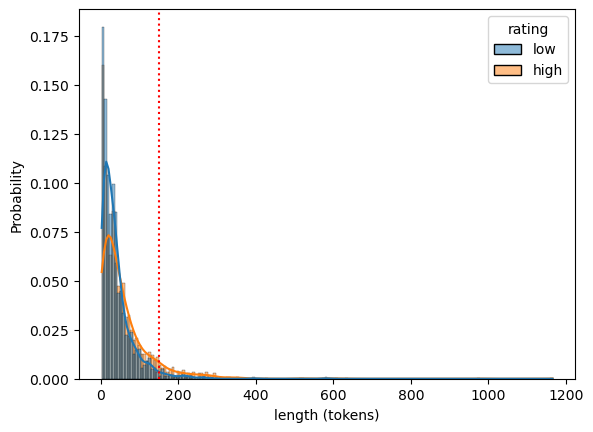

In [81]:
SEQUENCE_LENGTH = 150
ax = sns.histplot(data=df_ml, hue='rating', x='length (tokens)',kde=True,
                stat='probability',common_norm=False)#, estimator='median',);
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

## 📌BOOKMARK TO DO: Clean Up Below Here:

> FINISH END OF NOTEBOOK BELOW

In [82]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# # Define a function to calculate cosine similarity
# def find_closest_embeddings(embedding):
    
#     return sorted(vector_dict.keys(), key=lambda word: cosine_similarity([vector_dict[word]], [embedding]))

# # Example of finding words similar to 'vacuum' 
# similar_to_vacuum = find_closest_embeddings(vector_dict['vacuum'])[:5]  # Get the top 5 similar words

# # Print the similar words
# print("Words similar to 'vacuum':", similar_to_vacuum)

# # Demonstration of vector arithmetic: 'hate' + 'love' + 'vacuum'
# combined_vector = vector_dict['hate'] + vector_dict['love'] + vector_dict['vacuum']
# similar_to_combined = find_closest_embeddings(combined_vector)[:5]  # Get the top 5 similar words

# # Print the similar words to the combined vector
# print("Words similar to the combination of 'hate', 'love', and 'vacuum':", similar_to_combined)
# # 

In [83]:

# # Example of finding words similar to 'vacuum' 
# n_results = 5
# demo_word = 'vacuum'
# add_word = 'love'

# similar_to_vacuum = find_closest_embeddings(vector_dict[demo_word])[:n_results]  # Get the top 5 similar words

# # Print the similar words
# print(f"Words similar to '{demo_word}':")
# print(similar_to_vacuum)

# # Demonstration of vector arithmetic: 'hate' + 'love' + 'vacuum'
# combined_vector =vector_dict[add_word] + vector_dict[demo_word]# vector_dict['hate'] + 

# similar_to_combined = find_closest_embeddings(combined_vector)[:n_results]  # Get the top 5 similar words

# # Print the similar words to the combined vector
# print(f"\nWords similar to the combination of {demo_word} + {add_word}")
# print(similar_to_combined)


In [84]:

## Create text Vectorization layer
SEQUENCE_LENGTH=50 #BEST=50
EMBED_DIM = 100 # BEST= 200

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(ds_texts)


# Our First Deep Sequence Model

### Simple RNN

In [85]:

VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']


# Define sequential model with pre-trained vectorization layer and *new* embedding layer
model = Sequential([
    sequence_vectorizer,
    layers.Embedding(input_dim=VOCAB_SIZE,
                              output_dim=EMBED_DIM, 
                              input_length=SEQUENCE_LENGTH)
    ])

In [86]:
### BEST


def build_rnn_model(text_vectorization_layer):
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    model.add(layers.SimpleRNN(32)) #BEST=32
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',#'sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 50, 100)           516200    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 520,489
Trainable params: 520,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
63/63 [==============================] - 1s 7ms/step - loss: 0.6122 - accuracy: 0.6421 - val_loss: 0.55

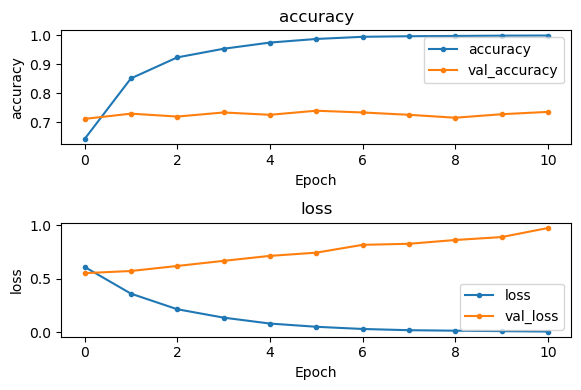

In [88]:
# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5),
)
fn.evaluate.plot_history(history,figsize=(6,4))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1006
           1       1.00      1.00      1.00      1006

    accuracy                           1.00      2012
   macro avg       1.00      1.00      1.00      2012
weighted avg       1.00      1.00      1.00      2012



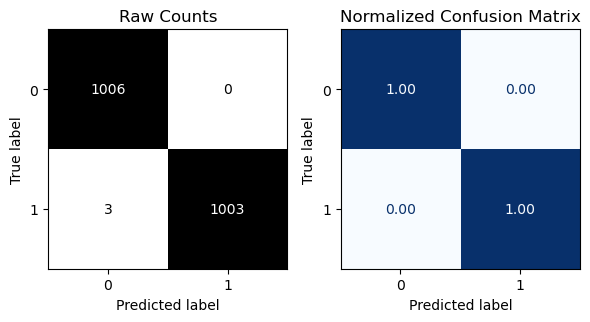


- Evaluating Training Data:
63/63 [==============================] - 0s 1ms/step - loss: 0.0109 - accuracy: 0.9985
{'loss': 0.010869856923818588, 'accuracy': 0.9985089302062988}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       275
           1       0.70      0.73      0.72       221

    accuracy                           0.74       496
   macro avg       0.74      0.74      0.74       496
weighted avg       0.74      0.74      0.74       496



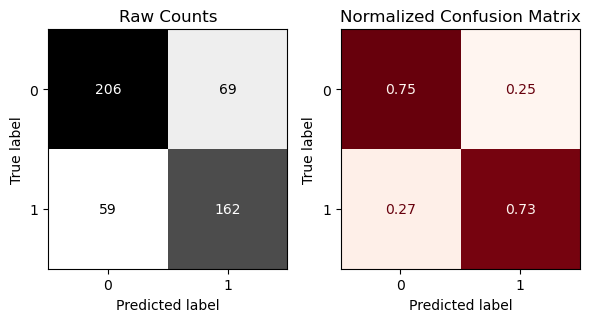


- Evaluating Test Data:
16/16 [==============================] - 0s 2ms/step - loss: 0.8965 - accuracy: 0.7419
{'loss': 0.8964506387710571, 'accuracy': 0.7419354915618896}


In [89]:
# Obtain the results
results = fn.evaluate.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

# APPENDIX - Save for Next Lecture

In [90]:
# raise Exception("Save for next lecture")

In [91]:
## TEMP/EXP - extract embedding matrix

embedding_weights = rnn_model.layers[1].get_weights()[0]
embedding_weights.shape

(5162, 100)

> - Conceptual example of using the maximum value as final result.
> - Relate to GlovalMaxPooling1D() layer

In [92]:
# Saving the MAX values (relate to GlobalMaxPooling)
max_vector = np.max((vector_dict['hate'], vector_dict['love'] ,vector_dict['vacuum']), axis=0)
print(max_vector.shape)
max_vector

(20,)


array([0.00170036, 0.00636358, 0.00422785, 0.0432061 , 0.04545214,
       0.00953519, 0.03622821, 0.04971505, 0.01225194, 0.02158299,
       0.02787178, 0.04725314, 0.01157136, 0.00900253, 0.02913921,
       0.03661792, 0.03127159, 0.01115788, 0.0428837 , 0.03408468],
      dtype=float32)

In [93]:
# Saving the Average values (relate to GlobalMaxPooling)
avg_vector = np.mean((vector_dict['hate'], vector_dict['love'] ,vector_dict['vacuum']), axis=0)
print(avg_vector.shape)
avg_vector

(20,)


array([-0.02835894, -0.02185575, -0.01894971,  0.02314247,  0.03797964,
       -0.00679046,  0.01399956, -0.00400156, -0.01445905, -0.00803309,
        0.01629478,  0.00848953, -0.02490254, -0.01312889, -0.00553736,
       -0.01723934,  0.00862554, -0.01132868,  0.0098577 , -0.01330624],
      dtype=float32)